# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from keras.models import Sequential # create a linear stack of neural network layers.
from keras.layers import Dense, Dropout # is a module that provides various layer types, including Dense and Dropout, used to define the architecture of the neural network.
from keras.callbacks import EarlyStopping #training is stopped early. This helps prevent overfitting

In [4]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# **Exploratory Data Analysis**

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
df.isnull().sum()


,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [7]:
# drop rows with missing values
df.dropna(axis=0, inplace=True)

In [8]:
df.shape


(20433, 10)

In [9]:
df['ocean_proximity'].value_counts()


,count
ocean_proximity,
<1H OCEAN,9034
INLAND,6496
NEAR OCEAN,2628
NEAR BAY,2270
ISLAND,5


In [10]:
df['ocean_proximity'] = df['ocean_proximity'].map({"<1H OCEAN":0,"INLAND":1,"NEAR OCEAN":2,"NEAR BAY":3,"ISLAND":4})


In [11]:
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


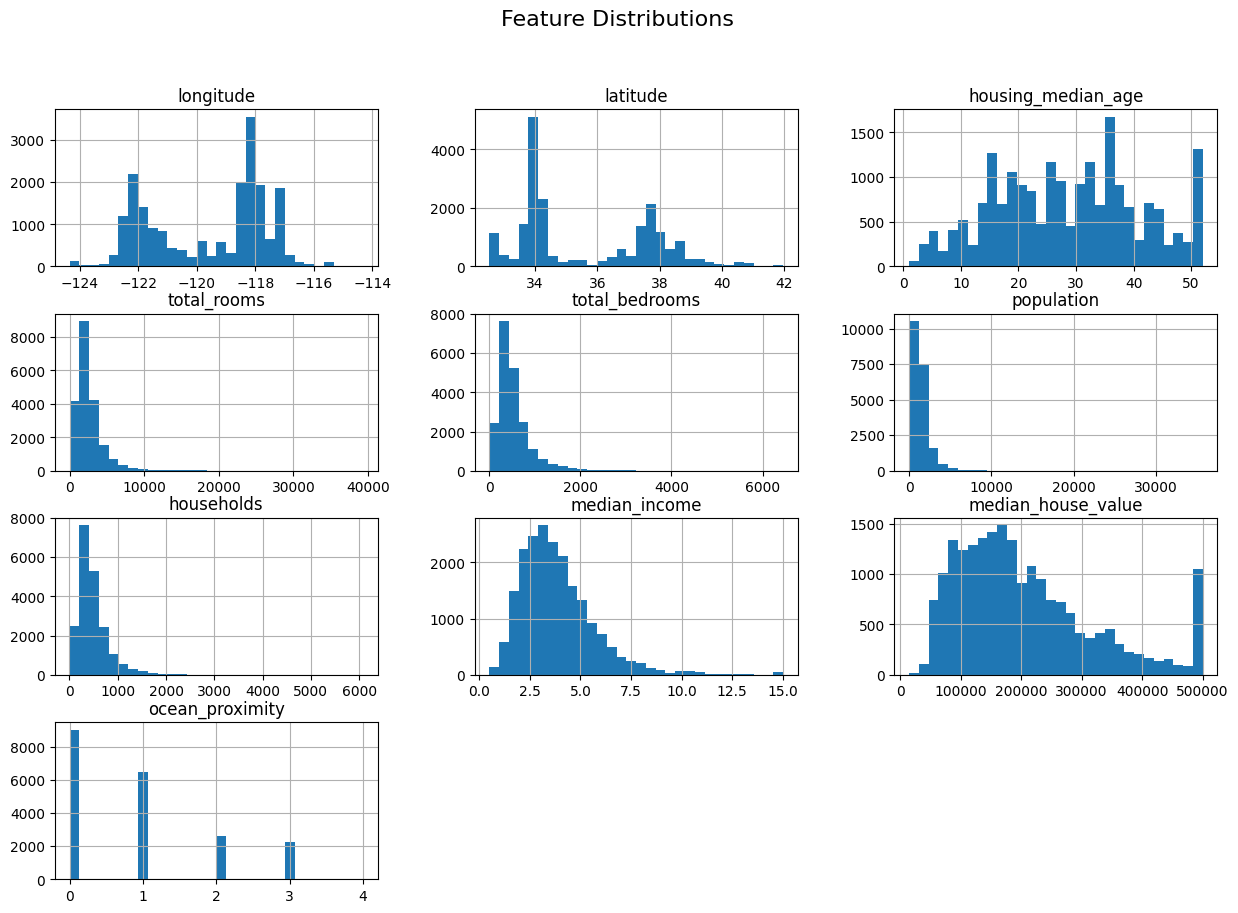

In [12]:
# Distribution plots for numeric features
num_cols = df.select_dtypes(include=[np.number]).columns

df[num_cols].hist(figsize=(15,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


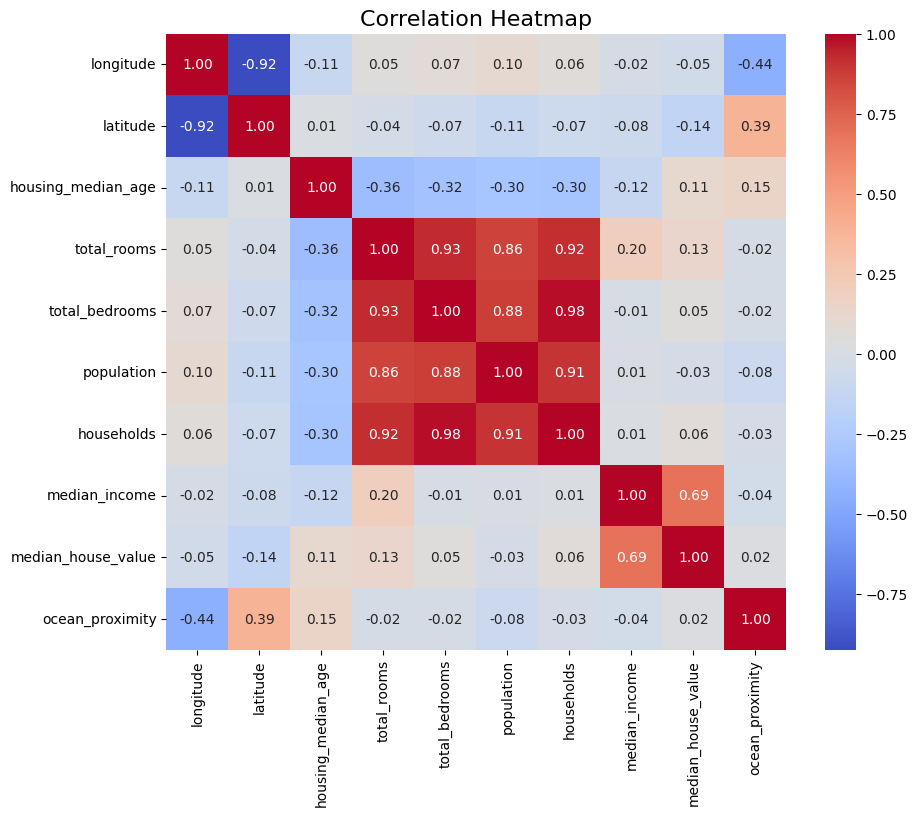

In [13]:
# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


## **Correlation Heatmap Insights**

1. **Geography (Longitude & Latitude)**
   - `longitude` and `latitude` are **highly negatively correlated** (-0.92).  
     → This makes sense because the dataset covers California, where longitude decreases as you move north.  

2. **Housing Characteristics**
   - `total_rooms`, `total_bedrooms`, `population`, and `households` are all **very highly correlated** (>0.9).  
     → These features are essentially measuring *scale of housing units* and may introduce **multicollinearity**.  
     → Feature engineering (e.g., `rooms_per_household`, `bedrooms_per_room`, `population_per_household`) could provide more meaningful insights.  

3. **Median Income**
   - Strongest correlation with `median_house_value` (0.69).  
     → Confirms that income is the **key driver** of house prices in this dataset.  

4. **Housing Age**
   - `housing_median_age` has weak negative correlations with most size-related variables.  
     → Suggests that newer neighborhoods may have slightly more/larger housing units.  

5. **Ocean Proximity**
   - Weak correlations overall, but spatial effects may be **non-linear** and better captured through categorical analysis or geospatial plots.  

6. **Target Variable (Median House Value)**
   - Positively correlated with `median_income` (0.69).  
   - Weak direct correlation with `total_rooms`, `population`, etc., indicating **size of housing units alone is not a strong price driver**.  
   - Suggests that **location and income** are more critical than raw housing size.  

---


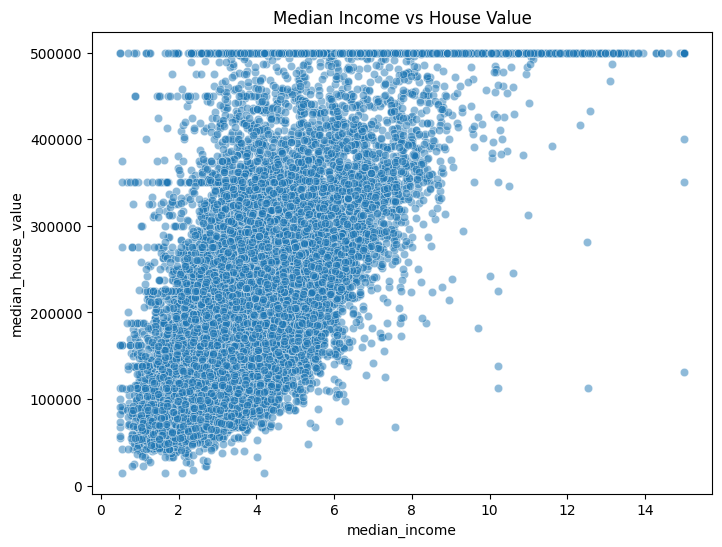

In [14]:
# Median income vs house value
plt.figure(figsize=(8,6))
sns.scatterplot(x="median_income", y="median_house_value", data=df, alpha=0.5)
plt.title("Median Income vs House Value")
plt.show()


## 📈** Median Income vs House Value Insights**

1. **Strong Positive Relationship**
   - As `median_income` increases, `median_house_value` also rises.  
   - Confirms that income levels are a strong predictor of housing prices.  

2. **Non-linear Trend**
   - The relationship is not perfectly linear: prices rise quickly at lower incomes, then start to flatten at higher incomes.  
   - Suggests that using **non-linear models** (like Decision Trees, Random Forests, or Gradient Boosting) may capture patterns better than simple linear regression.  

3. **Upper Cap at 500,000**
   - A clear **horizontal line at $500,000** indicates the dataset has a **capped target variable** (many homes are recorded at the maximum value).  
   - This is important because it introduces **censoring** — models may underestimate the true value of high-income areas.  

4. **Outliers**
   - A few points with very high income (>12) but relatively modest house values.  
   - Could be data entry noise or special cases (e.g., rural high-income households).  

5. **Key Takeaway**
   - `median_income` is the **single most informative feature** for predicting housing prices.  
   - However, modeling needs to address the **capping issue** and potentially transform `median_income` to capture the non-linear effect.


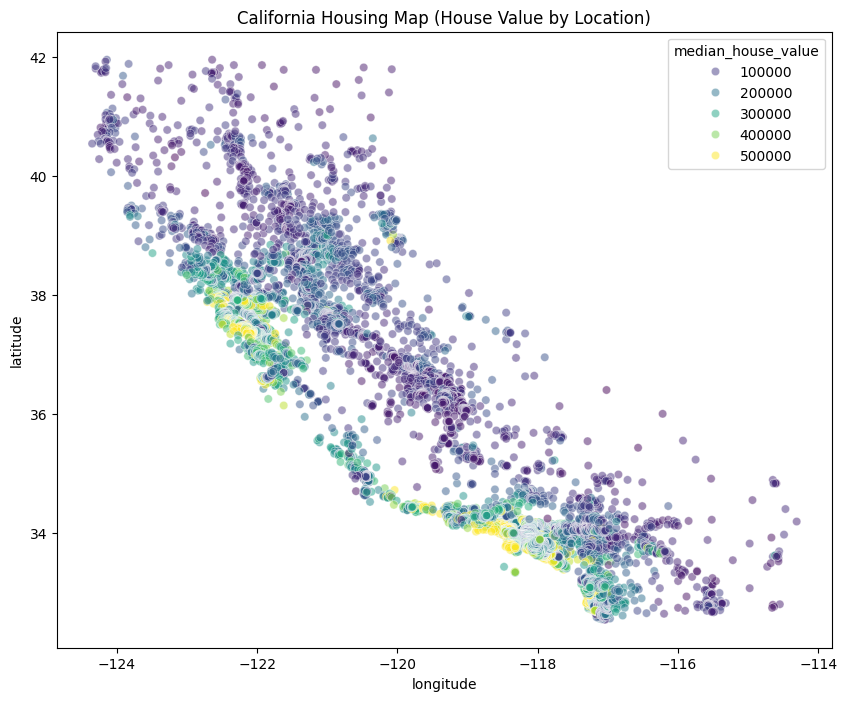

In [15]:
# Geo plot: longitude vs latitude, color = house value
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="longitude", y="latitude",
    hue="median_house_value",
    palette="viridis",
    data=df,
    alpha=0.5
)
plt.title("California Housing Map (House Value by Location)")
plt.show()


/tmp/ipython-input-4026870870.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="ocean_proximity", data=df, palette="viridis")


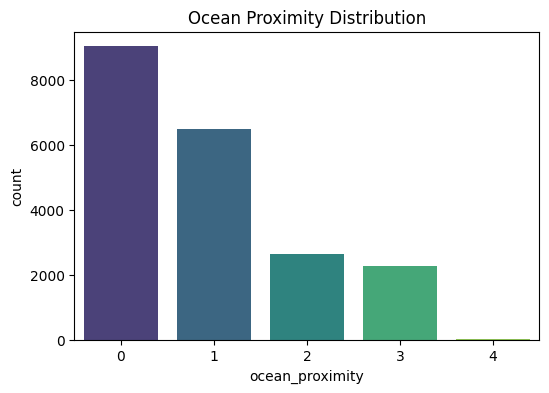

In [16]:
# Ocean proximity distribution
if "ocean_proximity" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="ocean_proximity", data=df, palette="viridis")
    plt.title("Ocean Proximity Distribution")
    plt.show()



## 🌊 **Ocean Proximity Encoding**

The categorical feature `ocean_proximity` was label-encoded as follows:

- **0 → `<1H OCEAN`**: Less than 1 hour drive to the ocean  
- **1 → `INLAND`**: Located inland, away from coastal influence  
- **2 → `NEAR OCEAN`**: Near the ocean  
- **3 → `NEAR BAY`**: Near a bay area  
- **4 → `ISLAND`**: On an island  

# **Train test split**


In [17]:
# Target variable is 'median_house_value'
y = df['median_house_value']
x = df.drop('median_house_value', axis=1)
print(x.shape)
print(y.shape)

(20433, 9)
(20433,)


In [18]:
# convert to numpy array
x = np.array(x)
y = np.array(y)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(16346, 9)
(4087, 9)
(16346,)
(4087,)


# **Min-Max Scaling**

In [20]:
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.transform(x_test)

In [21]:
print(x_train)
print(x_test)

[[0.54425229 0.30180659 0.66666667 ... 0.06101974 0.21336947 0.25      ]
 [0.30315361 0.58448459 0.56862745 ... 0.00707237 0.27586516 0.25      ]
 [0.6948118  0.16790648 0.09803922 ... 0.25542763 0.25377581 0.25      ]
 ...
 [0.23601221 0.51328374 0.68627451 ... 0.05411184 0.2810375  0.        ]
 [0.19226857 0.55366631 1.         ... 0.06069079 0.26132053 0.75      ]
 [0.51068159 0.19978746 0.43137255 ... 0.12648026 0.29727866 0.5       ]]
[[0.71922686 0.02231668 0.43137255 ... 0.09769737 0.18199749 0.5       ]
 [0.30620549 0.64718385 0.45098039 ... 0.07976974 0.19436284 0.25      ]
 [0.3387589  0.54091392 0.74509804 ... 0.09917763 0.08313678 0.25      ]
 ...
 [0.15055951 0.62274176 0.76470588 ... 0.06973684 0.23342437 0.        ]
 [0.6103764  0.17534538 1.         ... 0.04276316 0.29645798 0.        ]
 [0.72227874 0.08926674 0.25490196 ... 0.13289474 0.31384395 0.        ]]


In [22]:
x_train.shape[1]

9

# **ANN(Artificial Neural Network) Model**

In [23]:
model = Sequential([
    #input layer
    Dense(1000, input_shape=(x_train.shape[1],), activation='relu'),
    Dropout(0.2),
    #two hidden layers
    Dense(500, activation='relu'),
    Dropout(0.2),
    Dense(250, activation='relu'),
    #output layer
    Dense(1,activation='linear') # here 1 shows countinuous value(regression)
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │        10,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 636,001 (2.43 MB)

 Trainable params: 636,001 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

## 🧠 **Neural Network Model Architecture**

We designed a feed-forward neural network for **house value prediction**:

1. **Input Layer**
   - `Dense(1000, input_shape=(x_train.shape[1],), activation='relu')`  
   - 1000 neurons with ReLU activation.  
   - `input_shape=(x_train.shape[1],)` ensures the model accepts all input features.  
   - A large first layer helps capture complex feature interactions.  

**Total Parameters:** 636,001 (all trainable).

2. **Dropout (0.2)**
   - Randomly drops 20% of neurons during training to **reduce overfitting**.  

3. **Hidden Layers**
   - `Dense(500, activation='relu')` → mid-sized layer to reduce complexity.  
   - `Dropout(0.2)` → regularization.  
   - `Dense(250, activation='relu')` → smaller layer to compress learned features.  

4. **Output Layer**
   - `Dense(1, activation='linear')`  
   - A single neuron outputs a **continuous value** (regression).  
   - Linear activation is used since we’re predicting house prices (not a probability).  

### 🔍 Key Notes
- **ReLU activation** is used in hidden layers to handle non-linear relationships.  
- **Dropout** helps prevent overfitting, especially with deep networks.  
- The model outputs a **single scalar value** representing the predicted `median_house_value`.  



In [45]:
# Compile the model and set easlystoping
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
es = EarlyStopping(monitor='val_loss',mode='min',patience=50, restore_best_weights=True)

In [46]:
history = model.fit(x_train, y_train, validation_data= (x_test, y_test), callbacks=[es], epochs=10, batch_size=50, verbose=1)


Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4345134080.0000 - mae: 46228.2461 - val_loss: 4148326144.0000 - val_mae: 44079.4531
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4203180032.0000 - mae: 45833.7227 - val_loss: 4041668096.0000 - val_mae: 43963.2539
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4243020032.0000 - mae: 46108.4492 - val_loss: 4054283520.0000 - val_mae: 45448.9062
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4204723968.0000 - mae: 45719.1328 - val_loss: 4116238592.0000 - val_mae: 46192.6953
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4263327232.0000 - mae: 46249.1445 - val_loss: 3962490112.0000 - val_mae: 43758.9844
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4200997376.0000 - mae: 45780.2773 - val_loss: 4069437184.0000 - val_mae: 43777.2891
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4298504192.0000 - mae: 45968.4531 - val_loss: 3992596224.0000 - val_mae: 445

In [47]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_squared_log_error

y_pred = model.predict(x_test)
print("mae :", mean_absolute_error(y_test,y_pred))
print("mse :", mean_squared_error(y_test,y_pred))
print("mae :", mean_squared_log_error(y_test,y_pred))
print("score :", r2_score(y_test,y_pred))


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
mae : 43716.72862123807
mse : 3942479934.7475514
mae : 0.0911095726848862
score : 0.6925183747623245


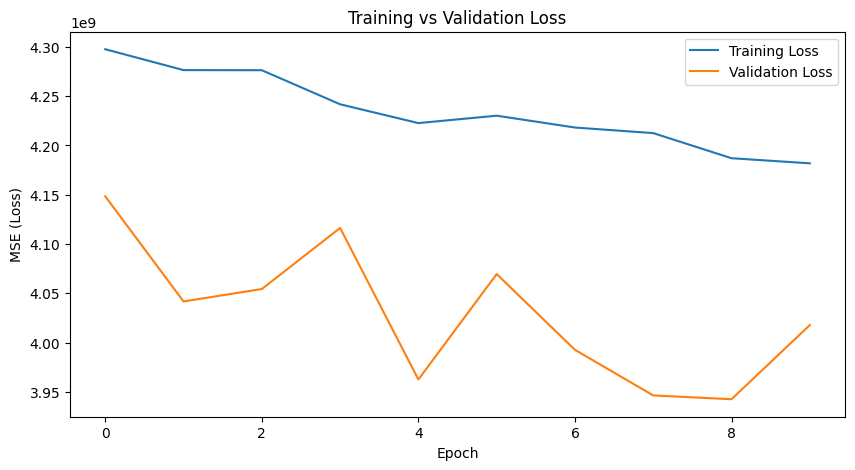

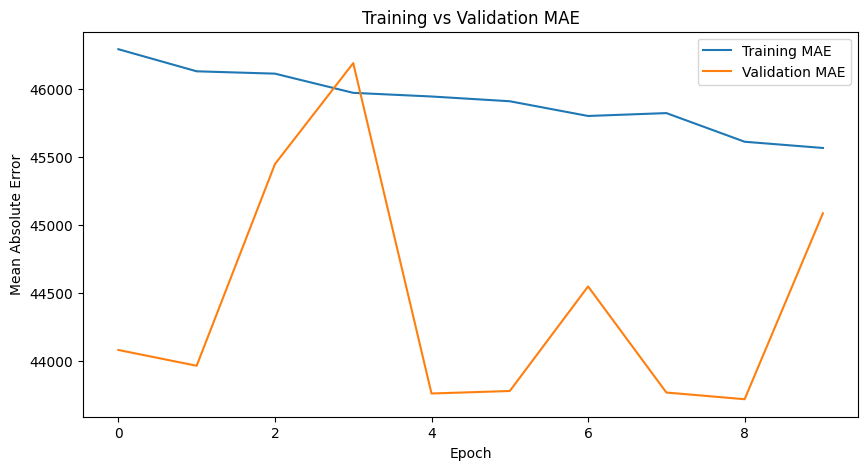

In [48]:
# 📊 Plot training history (Loss and MAE)
import matplotlib.pyplot as plt

# Plot Loss (MSE)
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (Loss)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs Validation MAE')
plt.legend()
plt.show()


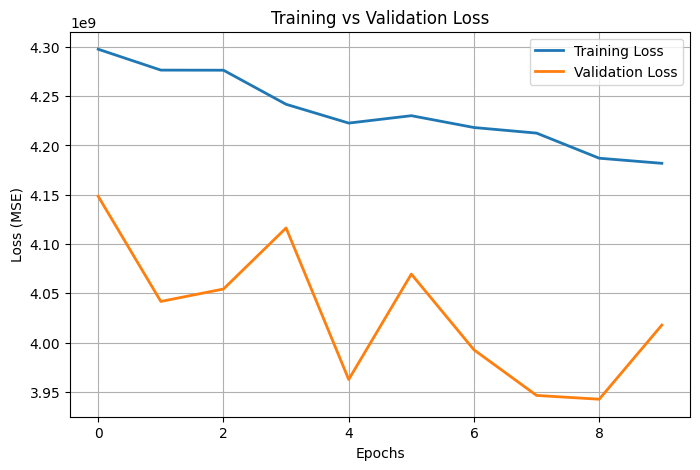

In [49]:
# 📉 Training vs Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# **tried with Adams Optimizer but didnt give results better then rmsprop**

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


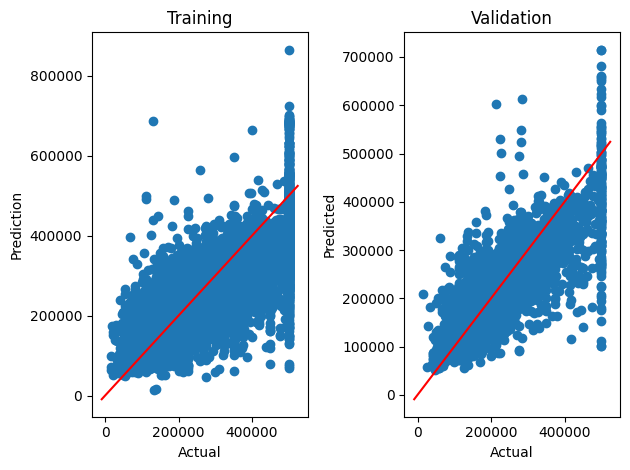

In [50]:
# Specify the dimensions
fig, axes = plt.subplots(1,2)

# This makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(x_train))
axes[0].set_xlabel('Actual', fontsize=10)
axes[0].set_ylabel('Prediction', fontsize=10)
axes[0].set_title('Training')

# Add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=y_test, y=model.predict(x_test))
axes[1].set_xlabel('Actual', fontsize=10)
axes[1].set_ylabel('Predicted', fontsize=10)
axes[1].set_title('Validation')

# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# Tight layout
fig.tight_layout()
plt.show()

In [51]:
def pred(longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity):
    features = np.array([longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity])
    features_scaled = min_max_scaler.fit_transform([features])
    results = model.predict(features_scaled).reshape(1,-1)
    return results[0]

In [52]:
longitude = -122.2300
latitude  = 37.8800
housing_median_age  = 41.0000
total_rooms        = 880.0000
total_bedrooms   =  129.0000
population     = 322.0000
households          =    126.0000
median_income       =      8.3252
ocean_proximity       =     3.0000

price = pred(longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


In [53]:
price #452600.00 is the actual value

array([603250.25], dtype=float32)

# **Save Model**

In [55]:
# Save
model.save("house_price_model.keras")

# Load
from tensorflow.keras.models import load_model
model = load_model("house_price_model.keras")


In [56]:
import sklearn
import tensorflow as tf
import keras

print("scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

scikit-learn version: 1.6.1
TensorFlow version: 2.19.0
Keras version: 3.10.0


In [58]:
# Download to your local machine
from google.colab import files
files.download("house_price_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>